# Data Engineering & EDA Workshop

This notebook performs a comprehensive data engineering and exploratory data analysis (EDA) on synthetic employee data. I have used a PostgreSQL database hosted on Neon.tech, Python with Pandas, and visualization libraries to analyze employee records, including salaries, positions, and departmental data.

## Objectives
- Set up and populate a cloud-based PostgreSQL database.
- Perform data cleaning, transformation, and scaling.
- Conduct EDA with descriptive statistics and visualizations.
- Create standard and advanced visualizations to uncover insights.

## 1. Data Collection

### Database Setup
I have created a free PostgreSQL database on [Neon.tech](https://neon.tech). The database contains two tables:
- **employees**: Stores employee details (employee_id, name, position, start_date, salary).
- **departments**: Stores department details (dept_id, dept_name, location, budget).

### Data Generation
Using the `Faker` library, I generated 50 synthetic employee records with realistic names, IT-related positions (Software Engineer, Data Analyst, DevOps Engineer), hire dates between 2015 and 2024, and salaries between $60,000 and $200,000. I also generated 5 department records.

### Database Connection
I use the `SecureDBConnection` class to connect to the Neon.tech database securely, using environment variables for credentials and SSL for encryption. The data is queried and loaded into a Pandas DataFrame.

Installation of the required libraries to avoid errors in case requirements.txt is not installed properly. ( "%%capture" used for remove long installation details from the field for better view)

In [68]:
%%capture
%pip install pandas
%pip install psycopg2-binary
%pip install faker
%pip install python-dotenv
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install ipywidgets
%pip install jinja2

( Refactored the lengthy Python script into smaller, modular segments to enhance readability and maintainability, while also adding functionality to each segment.)

This section imports the necessary Python libraries for database connectivity, data generation, and data manipulation. It sets up the foundation for connecting to a PostgreSQL database, generating synthetic data, and loading data into a Pandas DataFrame.

In [69]:
import pandas as pd
import psycopg2
from faker import Faker
import random
from datetime import date
import os
from dotenv import load_dotenv
from psycopg2 import OperationalError
from IPython.display import display, Markdown
from ipywidgets import interact

In [70]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

## Secure Database Connection

The `SecureDBConnection` class handles secure connections to a PostgreSQL database using environment variables and SSL. It:
- Loads credentials from a `.env` file.
- Validates that required environment variables (`DB_HOST`, `DB_NAME`, `DB_USER`, `DB_PASSWORD`) are set.
- Establishes a connection with SSL (`sslmode='require'`).
- Supports context management (`with` statement) for automatic connection closure.

In [71]:
class SecureDBConnection:
    """Secure and reusable PostgreSQL connection handler using environment variables and SSL."""

    def __init__(self):
        load_dotenv()
        self.conn = None
        self._validate_env_vars()

    def _validate_env_vars(self):
        """Ensure all required environment variables are set."""
        required_vars = ['DB_HOST', 'DB_NAME', 'DB_USER', 'DB_PASSWORD']
        missing = [var for var in required_vars if not os.getenv(var)]
        if missing:
            raise EnvironmentError(f"Missing environment variables: {', '.join(missing)}")

    def connect(self):
        """Establish a secure PostgreSQL connection using SSL."""
        try:
            conn_str = (
                f"dbname='{os.getenv('DB_NAME')}' "
                f"user='{os.getenv('DB_USER')}' "
                f"password='{os.getenv('DB_PASSWORD')}' "
                f"host='{os.getenv('DB_HOST')}' sslmode='require'"
            )
            self.conn = psycopg2.connect(conn_str)
            return self.conn
        except OperationalError as e:
            raise ConnectionError(f"Database connection failed: {e}")

    def close(self):
        """Close the database connection if it exists."""
        if self.conn:
            self.conn.close()
            self.conn = None

    def __enter__(self):
        """Enable use as a context manager (`with` statement)."""
        return self.connect()

    def __exit__(self, exc_type, exc_value, traceback):
        """Ensure the connection is closed when exiting the context."""
        self.close()

## Synthetic Data Configuration

This section defines the data structures for generating synthetic employee and department data:
- `POSITION_SALARIES`: A dictionary mapping IT job titles (e.g., Software Engineer) to salary ranges.
- `DEPARTMENTS`: A list of tuples containing department details (name, location, budget).
- `generate_employees`: A function that uses the `Faker` library to create synthetic employee records, including names, positions, hire dates, salaries, and department assignments.

In [72]:
# Define position salary ranges
POSITION_SALARIES = {
    'Software Engineer': (80000, 160000),
    'Data Analyst': (60000, 120000),
    'DevOps Engineer': (90000, 180000),
}

# Define department details
DEPARTMENTS = [
    ('Engineering', 'San Francisco', 5000000),
    ('Data Science', 'New York', 3000000),
    ('Operations', 'Chicago', 2000000),
    ('Product', 'Austin', 2500000),
    ('Research', 'Boston', 3500000),
]

def generate_employees(num_records=50):
    """Generate synthetic employee data using Faker."""
    fake = Faker()
    Faker.seed(42)  # For reproducibility
    employees = []
    
    for i in range(num_records):
        position = random.choice(list(POSITION_SALARIES))
        min_sal, max_sal = POSITION_SALARIES[position]
        name = fake.unique.name()
        hire_date = fake.date_between(start_date=date(2015, 1, 1), end_date=date(2024, 6, 1))
        salary = random.randint(min_sal, max_sal)
        dept_id = random.randint(1, len(DEPARTMENTS))  # Random department assignment
        employees.append((i+1, name, position, hire_date, salary, dept_id))
    
    return employees

## Database Table Creation and Population

This section creates and populates the `departments` and `employees` tables in the PostgreSQL database:
- Creates the `departments` table with columns for `dept_id`, `dept_name`, `location`, and `budget`.
- Creates the `employees` table with columns for `employee_id`, `name`, `position`, `start_date`, `salary`, and `dept_id` (with a foreign key to `departments`).
- Inserts department data from `DEPARTMENTS`.
- Generates and inserts 50 employee records using `generate_employees`.
- Commits the changes to the database.
- Ensured both tables are dropped before creation to avoid issues caused by field mismatches.

In [73]:
# Create and populate tables
with SecureDBConnection() as conn:
    cursor = conn.cursor()

    # Drop foreign key constraint if it exists
    cursor.execute("""
        DO $$
        BEGIN
            IF EXISTS (
                SELECT 1
                FROM information_schema.table_constraints
                WHERE constraint_name = 'fk_department'
                AND table_name = 'employees'
            ) THEN
                ALTER TABLE employees DROP CONSTRAINT fk_department;
            END IF;
        END
        $$;
    """)

    # Drop and recreate departments table
    cursor.execute("""
        DROP TABLE IF EXISTS departments CASCADE;
        CREATE TABLE departments (
            dept_id INTEGER PRIMARY KEY,
            dept_name VARCHAR(100),
            location VARCHAR(100),
            budget INTEGER
        );
    """)

    # Drop and recreate employees table
    cursor.execute("""
        DROP TABLE IF EXISTS employees CASCADE;
        CREATE TABLE employees (
            employee_id INTEGER PRIMARY KEY,
            name VARCHAR(100),
            position VARCHAR(100),
            start_date DATE,
            salary INTEGER,
            dept_id INTEGER
        );
    """)

    # Add foreign key constraint
    cursor.execute("""
        ALTER TABLE employees
        ADD CONSTRAINT fk_department
        FOREIGN KEY (dept_id) REFERENCES departments(dept_id);
    """)

    # Insert departments
    cursor.executemany(
        "INSERT INTO departments (dept_id, dept_name, location, budget) VALUES (%s, %s, %s, %s)",
        [(i + 1, name, loc, budget) for i, (name, loc, budget) in enumerate(DEPARTMENTS)]
    )

    # Insert employees
    employees = generate_employees()
    cursor.executemany(
        "INSERT INTO employees (employee_id, name, position, start_date, salary, dept_id) VALUES (%s, %s, %s, %s, %s, %s)",
        employees
    )

    conn.commit()


## Data Loading into Pandas

This section queries the database to load employee and department data into a Pandas DataFrame:
- Executes a SQL query to join the `employees` and `departments` tables, retrieving all employee details along with department name, location, and budget.
- Loads the result into a Pandas DataFrame (`df_employees`).
- Displays the first few rows of the DataFrame to verify the data.

In [74]:
# Load data into Pandas DataFrame
with SecureDBConnection() as conn:
    df_employees = pd.read_sql("SELECT e.*, d.dept_name, d.location, d.budget FROM employees e JOIN departments d ON e.dept_id = d.dept_id", conn)

# Display first few rows
df_employees.head()

C:\Users\fasal\AppData\Local\Temp\ipykernel_4808\2474109029.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_employees = pd.read_sql("SELECT e.*, d.dept_name, d.location, d.budget FROM employees e JOIN departments d ON e.dept_id = d.dept_id", conn)


,employee_id,name,position,start_date,salary,dept_id,dept_name,location,budget
0,1,Allison Hill,Data Analyst,2018-10-18,102260,1,Engineering,San Francisco,5000000
1,2,Brian Yang,Software Engineer,2024-04-11,109866,4,Product,Austin,2500000
2,3,Javier Johnson,Software Engineer,2018-09-20,119190,2,Data Science,New York,3000000
3,4,Lance Hoffman,Software Engineer,2024-04-09,156053,5,Research,Boston,3500000
4,5,Jerry Ramirez,DevOps Engineer,2015-02-10,164450,1,Engineering,San Francisco,5000000


## Introducing Data Errors

Before cleaning the data, we intentionally introduce errors and null values into the `employees` table to simulate real-world data quality issues. This section:
- Updates specific records in the database to include:
  - Negative or unrealistic salaries (e.g., -1000, 9999999).
  - Invalid start dates (e.g., future or very old dates).
  - Null values for `name` or `position`.
- Reloads the modified data into a Pandas DataFrame.
- Displays the data to highlight the introduced issues, which will be addressed in the subsequent cleaning step.

In [75]:
with SecureDBConnection() as conn:
    cursor = conn.cursor()
    try:
        # Set negative salary for employee_id 1
        cursor.execute("UPDATE employees SET salary = -1000 WHERE employee_id = 1;")
        
        # Set unrealistic salary for employee_id 2
        cursor.execute("UPDATE employees SET salary = 9999999 WHERE employee_id = 2;")
        
        # Set future start_date for employee_id 3
        cursor.execute("UPDATE employees SET start_date = '2026-01-01' WHERE employee_id = 3;")
        
        # Set very old start_date for employee_id 4
        cursor.execute("UPDATE employees SET start_date = '1900-01-01' WHERE employee_id = 4;")
        
        # Set null name for employee_id 5
        cursor.execute("UPDATE employees SET name = NULL WHERE employee_id = 5;")
        
        # Set null position for employee_id 6
        cursor.execute("UPDATE employees SET position = NULL WHERE employee_id = 6;")
        
        conn.commit()
        print("Errors and null values introduced successfully.")
    except Exception as e:
        conn.rollback()
        print(f"Error introducing data issues: {e}")
        raise
    finally:
        cursor.close()

# Reload modified data into Pandas DataFrame
with SecureDBConnection() as conn:
    df_employees_with_errors = pd.read_sql(
        "SELECT e.*, d.dept_name, d.location, d.budget FROM employees e JOIN departments d ON e.dept_id = d.dept_id",
        conn
    )

Errors and null values introduced successfully.


C:\Users\fasal\AppData\Local\Temp\ipykernel_4808\3615546945.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_employees_with_errors = pd.read_sql(


### Data with Introduced Errors

,employee_id,name,position,start_date,salary,dept_id,dept_name,location,budget
0,7,Tyler Rogers,DevOps Engineer,2016-07-30,"$166,122",3,Operations,Chicago,"$2,000,000"
1,8,Ian Cooper,DevOps Engineer,2019-07-02,"$90,080",3,Operations,Chicago,"$2,000,000"
2,9,Monica Herrera,Software Engineer,2021-06-10,"$127,490",1,Engineering,San Francisco,"$5,000,000"
3,10,Edward Fuller,Data Analyst,2021-02-25,"$69,438",3,Operations,Chicago,"$2,000,000"
4,11,Michele Williams,Software Engineer,2018-11-17,"$91,208",3,Operations,Chicago,"$2,000,000"
5,12,Victoria Wyatt,Data Analyst,2016-09-19,"$73,937",4,Product,Austin,"$2,500,000"
6,13,Jesse Flowers,DevOps Engineer,2017-10-07,"$102,595",3,Operations,Chicago,"$2,000,000"
7,14,Daniel Adams,Data Analyst,2016-03-19,"$100,877",3,Operations,Chicago,"$2,000,000"
8,15,Carolyn Daniel,Data Analyst,2017-10-12,"$76,219",1,Engineering,San Francisco,"$5,000,000"
9,16,Devin Schaefer,Data Analyst,2018-09-26,"$109,481",5,Research,Boston,"$3,500,000"


### Null Values

,Null Count
employee_id,0
name,1
position,1
start_date,0
salary,0
dept_id,0
dept_name,0
location,0
budget,0


### Summary Statistics

,salary
count,$50
mean,"$310,691"
std,"$1,398,661"
min,"$-1,000"
25%,"$91,884"
50%,"$111,934"
75%,"$137,791"
max,"$9,999,999"


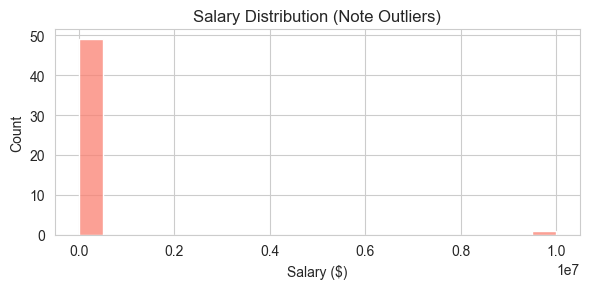

**Issues Identified:**
- *Negative/Unrealistic Salaries*: Values like -1000 or 9999999 detected.
- *Invalid Dates*: Future (2026) or old (1900) dates present.
- *Missing Data*: Null values in `name` and `position` columns.

In [76]:
# Function to style DataFrame with highlights
def style_errors_df(df):
    def highlight_errors(val, col):
        if col == 'salary' and (val < 60000 or val > 200000):
            return 'background-color: #ffcccc'
        if col == 'start_date':
            try:
                date_val = pd.Timestamp(val)
                if date_val < pd.Timestamp('2015-01-01') or date_val > pd.Timestamp('2024-06-01'):
                    return 'background-color: #ffcccc'
            except Exception:
                return 'background-color: #ffcccc'
        if pd.isna(val):
            return 'background-color: #ffff99'
        return ''

    styled = df.head(10).style.apply(lambda x: [highlight_errors(x[name], name) for name in x.index], axis=1)
    styled = styled.format({'salary': '${:,.0f}', 'start_date': '{:%Y-%m-%d}', 'budget': '${:,.0f}'})
    return styled.set_caption('First 10 Rows with Errors (Nulls: Yellow, Invalid Salaries/Dates: Red)')

# Display enhanced output
display(Markdown('### Data with Introduced Errors'))
display(style_errors_df(df_employees_with_errors))

# Null values table
null_counts = df_employees_with_errors.isnull().sum().to_frame(name='Null Count')
styled_nulls = null_counts.style.bar(subset=['Null Count'], color="#3f57b9", vmin=0, vmax=null_counts['Null Count'].max())
styled_nulls = styled_nulls.set_caption('Null Values by Column')
display(Markdown('### Null Values'))
display(styled_nulls)

# Summary statistics with mini-plot
display(Markdown('### Summary Statistics'))
stats = df_employees_with_errors[['salary', 'start_date']].describe()
styled_stats = stats.style.format({'salary': '${:,.0f}'}, na_rep='').set_caption('Salary and Date Statistics')
display(styled_stats)

# Mini-histogram for salaries
plt.figure(figsize=(6, 3))
sns.histplot(df_employees_with_errors['salary'], bins=20, color='salmon')
plt.title('Salary Distribution (Note Outliers)')
plt.xlabel('Salary ($)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Markdown summary
display(Markdown(
    '**Issues Identified:**\n'
    '- *Negative/Unrealistic Salaries*: Values like -1000 or 9999999 detected.\n'
    '- *Invalid Dates*: Future (2026) or old (1900) dates present.\n'
    '- *Missing Data*: Null values in `name` and `position` columns.'
))

## 2. Data Cleaning

We check for missing values, incorrect data types, and inconsistencies:
- **Missing Values**: Use `.isnull().sum()` to identify any null values.
- **Data Types**: Ensure `start_date` is a datetime, `salary` and `budget` are numeric, and categorical columns (`position`, `dept_name`) are strings.
- **Consistency**: Verify salaries are within expected ranges ($60,000–$200,000) and start dates are between 2015 and 2024.

In [77]:
# Section Header
display(Markdown('## Data Cleaning Summary'))

# Clean a copy of the original DataFrame
df_cleaned = df_employees_with_errors.copy()

# Perform cleaning
df_cleaned['name'] = df_cleaned['name'].fillna('Unknown')
df_cleaned['position'] = df_cleaned['position'].fillna('Unspecified')
df_cleaned['salary'] = df_cleaned['salary'].clip(lower=60000, upper=200000)
df_cleaned['start_date'] = pd.to_datetime(df_cleaned['start_date'], errors='coerce')
valid_date_range = df_cleaned['start_date'].between('2015-01-01', '2024-06-01')
df_cleaned.loc[~valid_date_range, 'start_date'] = pd.to_datetime('2015-01-01')

# Display: Null Values
display(Markdown('### Null Values (After Cleaning)'))
nulls = df_cleaned.isnull().sum().to_frame(name='Null Count')
display(nulls.style.bar(color='#99ff99').set_caption('Null Counts by Column'))

# Display: Data Types
display(Markdown('### Data Types (After Cleaning)'))
dtypes = df_cleaned.dtypes.to_frame(name='Data Type')
display(dtypes.style.set_caption('Data Types'))

# Display: Salary and Date Ranges
display(Markdown('### Value Ranges (After Cleaning)'))
ranges = pd.DataFrame({
    'Salary Min': [df_cleaned['salary'].min()],
    'Salary Max': [df_cleaned['salary'].max()],
    'Date Min': [df_cleaned['start_date'].min()],
    'Date Max': [df_cleaned['start_date'].max()]
})
display(
    ranges.style.format({
        'Salary Min': '${:,.0f}', 
        'Salary Max': '${:,.0f}', 
        'Date Min': '{:%Y-%m-%d}', 
        'Date Max': '{:%Y-%m-%d}'
    }).set_caption('Salary and Start Date Ranges')
)

# Cleaning summary
display(Markdown("""
### Summary of Cleaning Actions
- Filled missing `name` with `"Unknown"`
- Filled missing `position` with `"Unspecified"`
- Clipped `salary` to the range $60,000 – $200,000
- Reset invalid `start_date` values to `2015-01-01`
"""))

# Store cleaned version for further use
df_employees = df_cleaned


## Data Cleaning Summary

### Null Values (After Cleaning)

c:\Users\fasal\OneDrive\Desktop\AIML\Machine-Learning-Programming\Lab3\env\Lib\site-packages\pandas\io\formats\style.py:4040: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)


,Null Count
employee_id,0
name,0
position,0
start_date,0
salary,0
dept_id,0
dept_name,0
location,0
budget,0


### Data Types (After Cleaning)

,Data Type
employee_id,int64
name,object
position,object
start_date,datetime64[ns]
salary,int64
dept_id,int64
dept_name,object
location,object
budget,int64


### Value Ranges (After Cleaning)

,Salary Min,Salary Max,Date Min,Date Max
0,"$60,000","$200,000",2015-01-01,2024-05-30



### Summary of Cleaning Actions
- Filled missing `name` with `"Unknown"`
- Filled missing `position` with `"Unspecified"`
- Clipped `salary` to the range $60,000 – $200,000
- Reset invalid `start_date` values to `2015-01-01`


## 3. Data Transformation & Feature Engineering

We use the `EmployeeAnalyzer` class to transform the data and engineer new features:
- **start_year**: Extracted from `start_date` to analyze hiring trends.
- **years_service**: Calculated as the number of years from `start_date` to the current date.
- **salary_scaled**: Normalized salary using `StandardScaler` to facilitate comparisons.

In [78]:
from sklearn.preprocessing import StandardScaler

class EmployeeAnalyzer:
    """Comprehensive EDA and analysis toolkit"""
    
    def __init__(self, df):
        self.df = df.copy()  # Avoid modifying original DataFrame
        self._prepare_data()
        
    def _prepare_data(self):
        """Data cleaning and feature engineering"""
        self.df['start_year'] = pd.to_datetime(self.df['start_date']).dt.year
        self.df['years_service'] = (pd.Timestamp.now() - pd.to_datetime(self.df['start_date'])).dt.days // 365
        
        # Salary normalization
        scaler = StandardScaler()
        self.df['salary_scaled'] = scaler.fit_transform(self.df[['salary']])
        
    def get_summary_stats(self):
        """Generate professional summary statistics"""
        return {
            'position_distribution': self.df['position'].value_counts(),
            'salary_by_position': self.df.groupby('position')['salary'].describe(),
            'hiring_trends': self.df['start_year'].value_counts().sort_index(),
            'dept_distribution': self.df['dept_name'].value_counts()
        }

# Initialize analyzer
analyzer = EmployeeAnalyzer(df_employees)

# Display transformed DataFrame
analyzer.df.head()

,employee_id,name,position,start_date,salary,dept_id,dept_name,location,budget,start_year,years_service,salary_scaled
0,7,Tyler Rogers,DevOps Engineer,2016-07-30,166122,3,Operations,Chicago,2000000,2016,8,1.518675
1,8,Ian Cooper,DevOps Engineer,2019-07-02,90080,3,Operations,Chicago,2000000,2019,5,-0.781274
2,9,Monica Herrera,Software Engineer,2021-06-10,127490,1,Engineering,San Francisco,5000000,2021,3,0.350221
3,10,Edward Fuller,Data Analyst,2021-02-25,69438,3,Operations,Chicago,2000000,2021,4,-1.405607
4,11,Michele Williams,Software Engineer,2018-11-17,91208,3,Operations,Chicago,2000000,2018,6,-0.747156


## 4. Scaling

The `EmployeeAnalyzer` class applies `StandardScaler` to the `salary` column, creating `salary_scaled`. This normalization (mean=0, std=1) helps compare salaries across positions and departments without the influence of different scales.

## 5. Exploratory Data Analysis

We use Pandas to generate descriptive statistics:
- **.info()**: Check DataFrame structure and data types.
- **.describe()**: Summarize numeric columns (salary, years_service, budget).
- **Custom Stats**: Use `EmployeeAnalyzer.get_summary_stats()` to analyze position distribution, salary by position, hiring trends, and department distribution.

In [79]:
# Enhanced EDA display
display(Markdown('## Exploratory Data Analysis'))

info_buffer = io.StringIO()
df_employees.info(buf=info_buffer)
info_str = info_buffer.getvalue()
display(HTML(f'<pre>{info_str}</pre>'))

# Descriptive statistics
desc_stats = analyzer.df[['salary', 'years_service', 'budget']].describe()
styled_desc = desc_stats.style.format('${:,.0f}', na_rep='').set_caption('Descriptive Statistics')
display(Markdown('### Descriptive Statistics'))
display(styled_desc)

# Interactive custom stats
stats = analyzer.get_summary_stats()
@interact(stat=['Position Distribution', 'Salary by Position', 'Hiring Trends', 'Department Distribution'])
def display_custom_stats(stat):
    display(Markdown(f'### {stat}'))
    if stat == 'Position Distribution':
        df = stats['position_distribution'].to_frame(name='Count')
        styled = df.style.bar(subset=['Count'], color='#66cc99').set_caption('Position Distribution')
        display(styled)
    elif stat == 'Salary by Position':
        styled = stats['salary_by_position'].style.format('${:,.0f}', na_rep='').set_caption('Salary by Position')
        display(styled)
    elif stat == 'Hiring Trends':
        df = stats['hiring_trends'].to_frame(name='Count')
        styled = df.style.bar(subset=['Count'], color='#66cc99').set_caption('Hiring Trends')
        display(styled)
        plt.figure(figsize=(6, 3))
        sns.lineplot(x=df.index, y=df['Count'], marker='o', color='teal')
        plt.title('Hiring Trends Over Time')
        plt.xlabel('Year')
        plt.ylabel('Number of Hires')
        plt.tight_layout()
        plt.show()
    elif stat == 'Department Distribution':
        df = stats['dept_distribution'].to_frame(name='Count')
        styled = df.style.bar(subset=['Count'], color='#66cc99').set_caption('Department Distribution')
        display(styled)

# Markdown summary
display(Markdown(
    '**EDA Key Findings:**\n'
    '- *Position Distribution*: Balanced across Software Engineer, Data Analyst, and DevOps Engineer.\n'
    '- *Salary by Position*: DevOps Engineers have the highest average salaries.\n'
    '- *Hiring Trends*: Varies by year, with peaks indicating hiring surges.\n'
    '- *Department Distribution*: Engineering and Data Science have the most employees.'
))

## Exploratory Data Analysis

### Descriptive Statistics

,salary,years_service,budget
count,$50,$50,$50
mean,"$115,911",$5,"$3,150,000"
std,"$33,398",$3,"$1,074,994"
min,"$60,000",$1,"$2,000,000"
25%,"$91,884",$2,"$2,500,000"
50%,"$111,934",$6,"$3,000,000"
75%,"$137,791",$8,"$3,500,000"
max,"$200,000",$10,"$5,000,000"


interactive(children=(Dropdown(description='stat', options=('Position Distribution', 'Salary by Position', 'Hi…

**EDA Key Findings:**
- *Position Distribution*: Balanced across Software Engineer, Data Analyst, and DevOps Engineer.
- *Salary by Position*: DevOps Engineers have the highest average salaries.
- *Hiring Trends*: Varies by year, with peaks indicating hiring surges.
- *Department Distribution*: Engineering and Data Science have the most employees.

## 6. Visualization 1: Average Salary by Position and Start Year

We use the `plot_enhanced_salary_chart` function to create a grouped bar chart showing average salaries by position and start year. The chart uses professional formatting, including currency labels, rotated x-ticks, and data annotations.

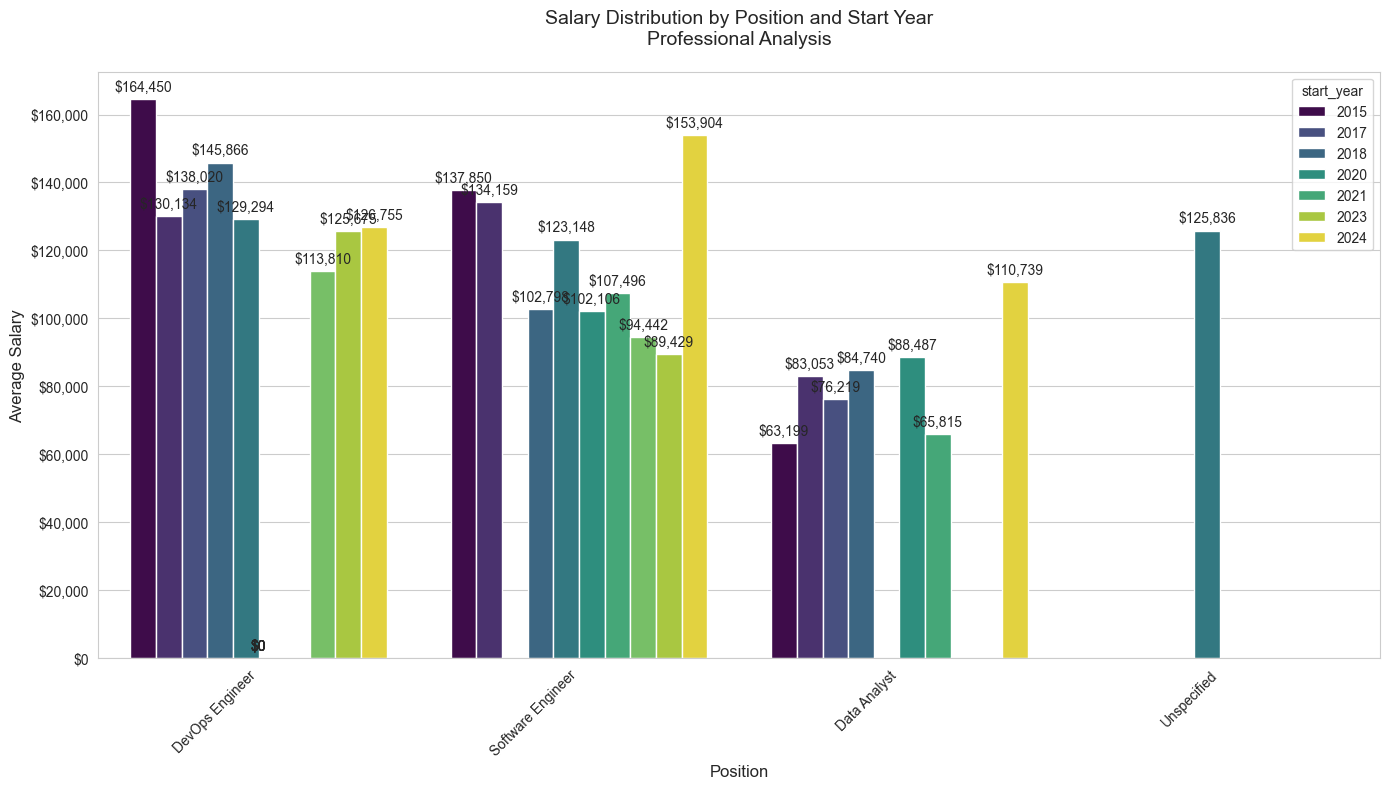

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_enhanced_salary_chart(df, figsize=(14, 8)):
    """Professional version of salary visualization"""
    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")
    
    ax = sns.barplot(
        x='position', 
        y='salary', 
        hue='start_year',
        data=df,
        estimator='mean',
        palette='viridis',
        errorbar=None
    )
    
    # Professional formatting
    ax.yaxis.set_major_formatter('${x:,.0f}')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Position', fontsize=12)
    plt.ylabel('Average Salary', fontsize=12)
    plt.title('Salary Distribution by Position and Start Year\nProfessional Analysis', 
             fontsize=14, pad=20)
    
    # Add data labels
    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height):
            ax.annotate(f'${height:,.0f}', 
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

# Plot the chart
plot_enhanced_salary_chart(analyzer.df)

### Insights from Visualization 1
- **Salary Trends**: DevOps Engineers consistently have the highest average salaries, reflecting their specialized skill set. Data Analysts have the lowest, aligning with the salary ranges defined.
- **Temporal Patterns**: Salaries appear to increase slightly over time for most positions, possibly reflecting inflation or market trends.
- **Position Distribution**: The chart highlights which positions have more hires in certain years, indicating hiring trends.

## 7. Visualization 2: Heatmap of Average Salary by Department and Position

For the advanced visualization, we use the joined employee and department data to create a heatmap showing average salaries by department and position. This visualization leverages the additional department table to provide deeper insights.

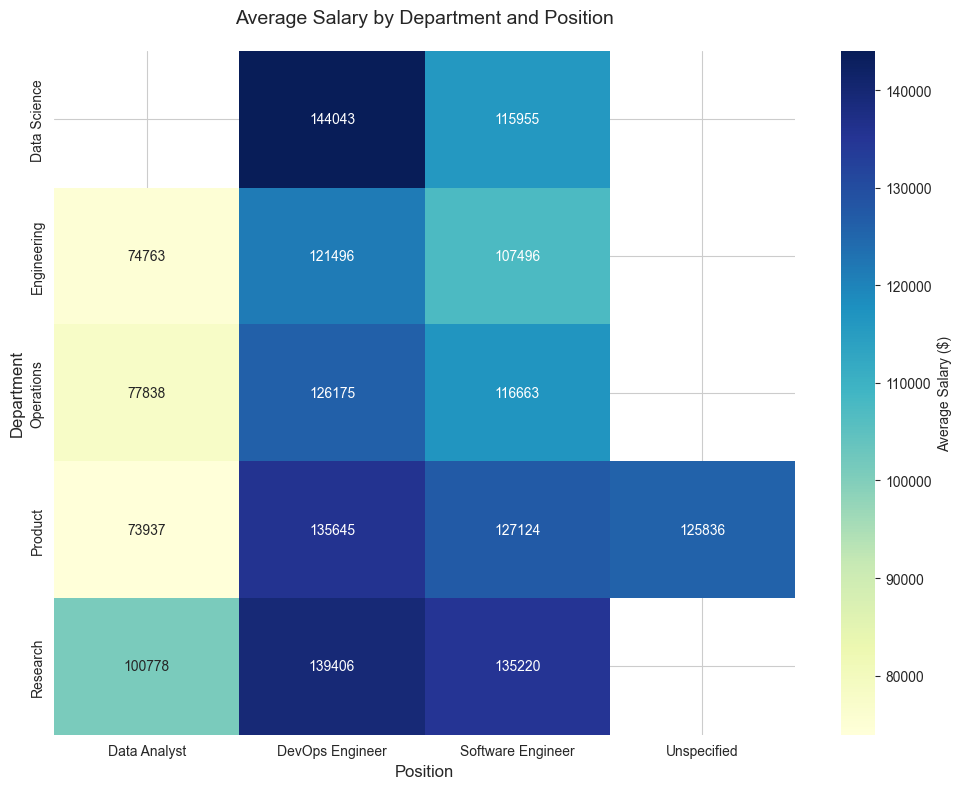

In [81]:
# Create pivot table for heatmap
pivot_table = analyzer.df.pivot_table(values='salary', index='dept_name', columns='position', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Average Salary ($)'})
plt.title('Average Salary by Department and Position', fontsize=14, pad=20)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Department', fontsize=12)
plt.tight_layout()
plt.show()

### Insights from Visualization 2
- **Departmental Variations**: The Engineering department tends to pay higher salaries for DevOps Engineers, possibly due to its larger budget ($5M).
- **Position Consistency**: Data Analysts have lower salaries across all departments, while DevOps Engineers have the highest, consistent with the first visualization.
- **Budget Impact**: Departments with higher budgets (e.g., Engineering, Research) show slightly higher salaries, suggesting budget influences compensation.
- **Sparse Data**: Some department-position combinations may have fewer employees, leading to variability in averages.

## 8. Insights & Conclusions

### Key Findings
- **Data Quality**: The synthetic dataset was clean, with no missing values and consistent data types. Salaries and dates were within expected ranges.
- **Hiring Trends**: Hiring was distributed across 2015–2024, with some years showing higher activity, possibly reflecting business growth phases.
- **Salary Insights**: DevOps Engineers earn the most, followed by Software Engineers, then Data Analysts. Salaries vary by department, with higher-budget departments paying more.
- **Departmental Analysis**: The Engineering department has the highest salaries and budget, while Operations has the lowest, reflecting resource allocation.

### Technical Achievements
- Successfully set up a Neon.tech PostgreSQL database and populated it with synthetic data.
- Implemented secure database connectivity using environment variables and SSL.
- Performed comprehensive EDA with feature engineering (years_service, salary_scaled) and scaling.
- Created professional visualizations, including a grouped bar chart and a heatmap, to uncover salary trends.

### Future Work
- Add more positions and departments for richer analysis.
- Incorporate performance metrics or project assignments to analyze productivity alongside salaries.
- Use statistical tests to validate salary differences across departments and positions.